<a href="https://colab.research.google.com/github/anvarbek11/Data-science/blob/main/TashknetCityHousePricePredicting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏡 Apartment Price Prediction in Tashkent
In this project, we predict apartment prices in Tashkent using structured real estate data. This is a supervised regression task using features like location, size, number of rooms, and floor information.

We’ll explore the data, visualize trends, clean & preprocess features, and train several ML models to evaluate performance.

Dataset exploration

In [102]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/anvarnarz/praktikum_datasets/main/housing_data_08-02-2021.csv')
df.head()

,location,district,rooms,size,level,max_levels,price
0,"город Ташкент, Юнусабадский район, Юнусабад 8-...",Юнусабадский,3,57,4,4,52000
1,"город Ташкент, Яккасарайский район, 1-й тупик ...",Яккасарайский,2,52,4,5,56000
2,"город Ташкент, Чиланзарский район, Чиланзар 2-...",Чиланзарский,2,42,4,4,37000
3,"город Ташкент, Чиланзарский район, Чиланзар 9-...",Чиланзарский,3,65,1,4,49500
4,"город Ташкент, Чиланзарский район, площадь Актепа",Чиланзарский,3,70,3,5,55000


In [103]:
#I am checking types and missing values
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   location    7565 non-null   object
 1   district    7565 non-null   object
 2   rooms       7565 non-null   int64 
 3   size        7565 non-null   object
 4   level       7565 non-null   int64 
 5   max_levels  7565 non-null   int64 
 6   price       7565 non-null   object
dtypes: int64(3), object(4)
memory usage: 413.8+ KB


,0
location,0
district,0
rooms,0
size,0
level,0
max_levels,0
price,0


Data cleaning

In [104]:
#First we will clean numeric columns
#Converting to numeric values invalid parsing will be NaN
numeric_cols = ['rooms','size','level','max_levels','price']
for col in numeric_cols:
  df[col]=pd.to_numeric(df[col],errors='coerce')
#We will fill NaN values with median
for col in numeric_cols:
  df[col]=df[col].fillna(df[col].median())

Feature engineering

In [105]:
#We encode district
df = pd.get_dummies(df,columns=['district'],drop_first=True)
#We add floor ration
df['floor_ratio'] = df['level']/df['max_levels']

In [106]:
df.head()
df=df.drop('location',axis=1)

Data visuzlization

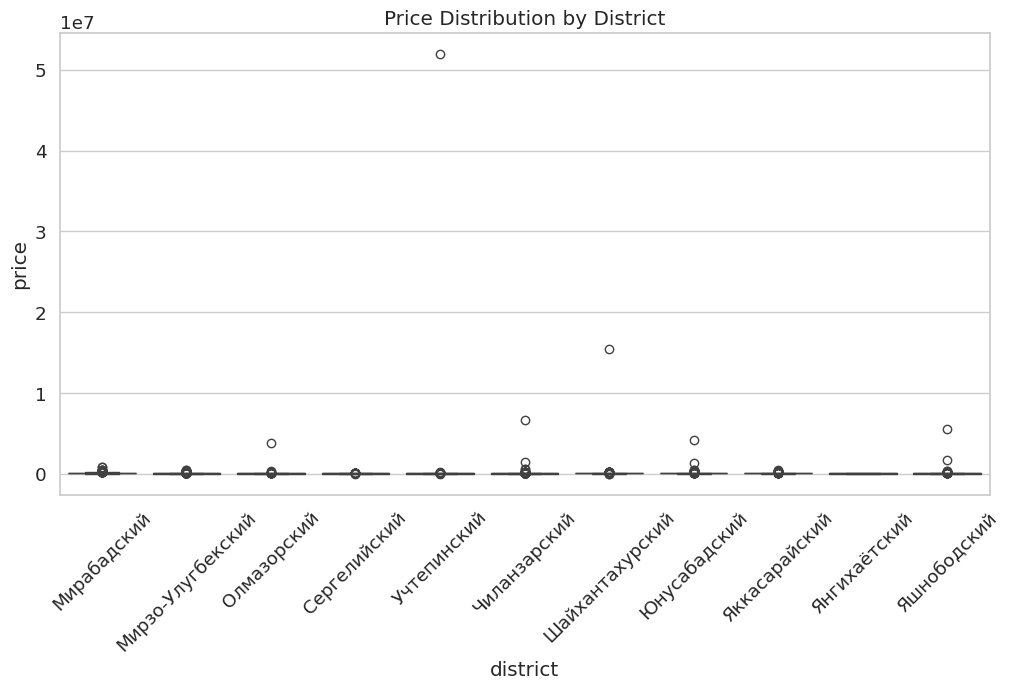

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt district columns back for visualization
districts = [col for col in df.columns if 'district_' in col]
melted_df = df.melt(id_vars=['price'], value_vars=districts, var_name='district', value_name='is_district')
melted_df = melted_df[melted_df['is_district']].drop('is_district', axis=1)
melted_df['district'] = melted_df['district'].str.replace('district_', '')

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=melted_df, x='district', y='price', hue='district',legend=False)
plt.xticks(rotation=45)
plt.title('Price Distribution by District')
plt.show()

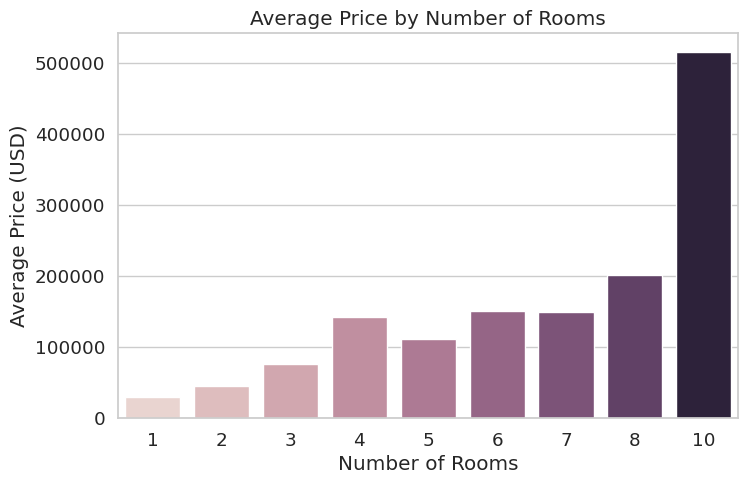

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
#Average Price by Number of Rooms
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='rooms', y='price', estimator='mean', errorbar=None, hue='rooms',legend=False)
plt.title('Average Price by Number of Rooms')
plt.xlabel('Number of Rooms')
plt.ylabel('Average Price (USD)')
plt.show()


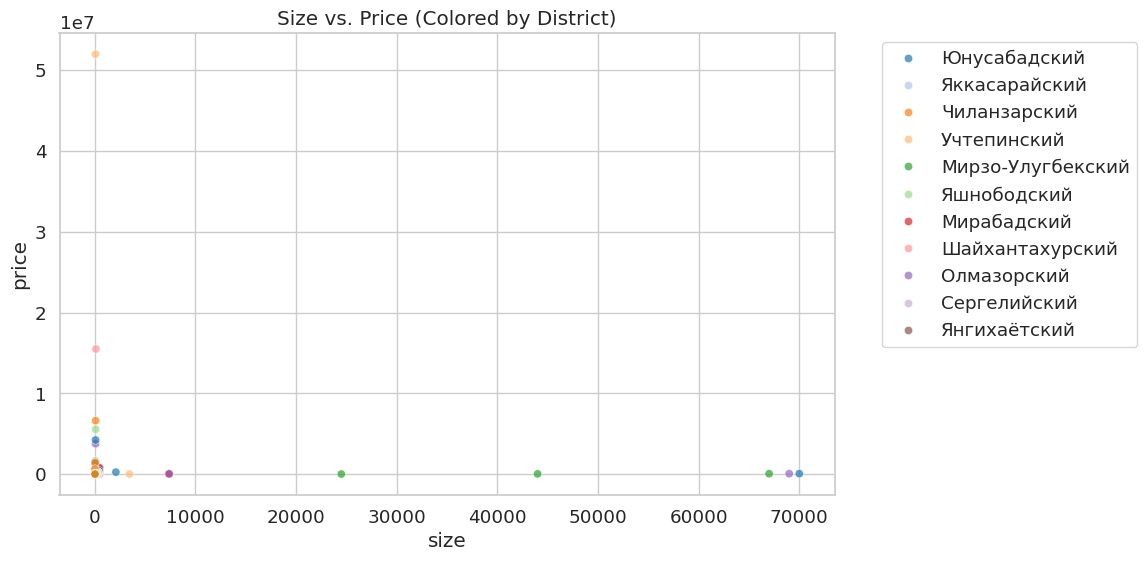

In [109]:
# Add district name as a column
df['district_name'] = df[districts].idxmax(axis=1).str.replace('district_', '')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='size', y='price', hue='district_name', palette='tab20', alpha=0.7)
plt.title('Size vs. Price (Colored by District)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

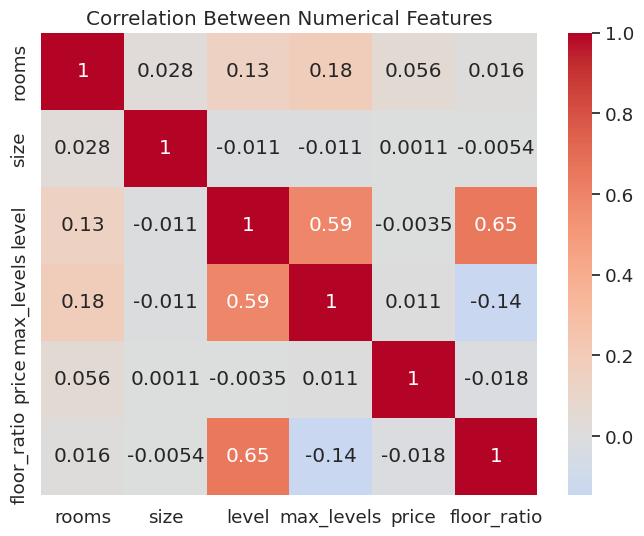

In [110]:
numerical_cols = ['rooms', 'size', 'level', 'max_levels', 'price', 'floor_ratio']
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Numerical Features')
plt.show()

In [112]:
import numpy as np
import pandas as pd

def clean_data(df):
    # Filter with .loc and create explicit copy
    df_clean = df.loc[
        (df['size'].between(20, 500)) &
        (df['price'].between(1e4, 2e6)) &
        (df['level'] <= df['max_levels'])
    ].copy()

    # Safe column assignment with .loc
    df_clean.loc[:, 'price'] = np.log1p(df_clean['price'])
    df_clean.loc[:, 'size'] = np.log1p(df_clean['size'])

    return df_clean

# Usage
df_clean = clean_data(df)

Modelling

In [116]:
df_clean = df_clean.drop('district_name',axis=1)

In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_absolute_error
X=df_clean.drop('price',axis=1)
y = df_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=111)


In [118]:
# I am making pipelines
lr_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('model',LinearRegression())
])
rf_pipe = Pipeline([
    ('model',RandomForestRegressor())
])
xgb_pipe = Pipeline([
    ('model',XGBRegressor(random_state=111))
])

In [119]:
# I am doing hyperparameter tuning
lr_params = {
    'model__fit_intercept':[True,False]
}
rf_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]

}
xgb_params = {
    'model__n_estimators': [100, 200],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 6]
}
#GridSearchCV setup
lr_grid = GridSearchCV(lr_pipe,lr_params,cv=5,scoring='r2')
rf_grid = GridSearchCV(rf_pipe,rf_params,cv=5,scoring='r2')
xgb_grid=GridSearchCV(xgb_pipe,xgb_params,cv=5,scoring='r2')

In [120]:
models = {
    'Linear Regression':lr_grid,
    'Random Forest':rf_grid,
    'XGBoost':xgb_grid
}
results = {}
for name,model in models.items():
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  results[name] = {
      'Best params':model.best_params_,
      'R2 score':r2_score(y_test,y_pred),
      'MAE':mean_absolute_error(y_test,y_pred)
  }
results_df = pd.DataFrame(results).T
print(results_df)

                                                         Best params  \
Linear Regression                     {'model__fit_intercept': True}   
Random Forest      {'model__max_depth': None, 'model__min_samples...   
XGBoost            {'model__learning_rate': 0.1, 'model__max_dept...   

                   R2 score       MAE  
Linear Regression  0.680964   0.20455  
Random Forest      0.770014  0.160533  
XGBoost             0.76534  0.163497  


In [124]:
results_df = pd.DataFrame(results).T.reset_index()
results_df.columns = ['Model', 'Best Parameters', 'R2 Score', 'MAE']
print(results_df.to_string(index=False))

            Model                                                                       Best Parameters  R2 Score       MAE
Linear Regression                                                        {'model__fit_intercept': True}  0.680964   0.20455
    Random Forest {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 200}  0.770014  0.160533
          XGBoost      {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200}   0.76534  0.163497


As we can see Random Forest is the best model with R2_score = 0.77 and XGBoost is slightly lower with R_score = 0.76